# E-Commerce Fraud Detection Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,  StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC



from sklearn.metrics import (ConfusionMatrixDisplay, 
                            classification_report, 
                            confusion_matrix, 
                            average_precision_score,
                            precision_recall_curve)

## 1. Data Loading and Preview

In [2]:
# Load the dataset
df = pd.read_csv("dataecom.csv")

# Define the target column
target = "Is Fraudulent"

# Check class balance (fraud is typically a rare event)
fraud_rate = df[target].mean()
print(f"Fraud rate: {fraud_rate:.4%} ({df[target].sum()} fraud out of {len(df)})")

# Preview of the data
df.info()
df.head()

Fraud rate: 5.1705% (1222 fraud out of 23634)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction ID      23634 non-null  object 
 1   Customer ID         23634 non-null  object 
 2   Transaction Amount  23634 non-null  float64
 3   Transaction Date    23634 non-null  object 
 4   Payment Method      23634 non-null  object 
 5   Product Category    23634 non-null  object 
 6   Quantity            23634 non-null  int64  
 7   Customer Age        23634 non-null  int64  
 8   Customer Location   23634 non-null  object 
 9   Device Used         23634 non-null  object 
 10  IP Address          23634 non-null  object 
 11  Shipping Address    23634 non-null  object 
 12  Billing Address     23634 non-null  object 
 13  Is Fraudulent       23634 non-null  int64  
 14  Account Age Days    23634 non-null  int64  
 15  Transac

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,c12e07a0-8a06-4c0d-b5cc-04f3af688570,8ca9f102-02a4-4207-ab63-484e83a1bdf0,42.32,2024-03-24 23:42:43,PayPal,electronics,1,40,East Jameshaven,desktop,110.87.246.85,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,0,282,23
1,7d187603-7961-4fce-9827-9698e2b6a201,4d158416-caae-4b09-bd5b-15235deb9129,301.34,2024-01-22 00:53:31,credit card,electronics,3,35,Kingstad,tablet,14.73.104.153,"5230 Stephanie Forge\nCollinsbury, PR 81853","5230 Stephanie Forge\nCollinsbury, PR 81853",0,223,0
2,f2c14f9d-92df-4aaf-8931-ceaf4e63ed72,ccae47b8-75c7-4f5a-aa9e-957deced2137,340.32,2024-01-22 08:06:03,debit card,toys & games,5,29,North Ryan,desktop,67.58.94.93,"195 Cole Oval\nPort Larry, IA 58422","4772 David Stravenue Apt. 447\nVelasquezside, ...",0,360,8
3,e9949bfa-194d-486b-84da-9565fca9e5ce,b04960c0-aeee-4907-b1cd-4819016adcef,95.77,2024-01-16 20:34:53,credit card,electronics,5,45,Kaylaville,mobile,202.122.126.216,"7609 Cynthia Square\nWest Brenda, NV 23016","7609 Cynthia Square\nWest Brenda, NV 23016",0,325,20
4,7362837c-7538-434e-8731-0df713f5f26d,de9d6351-b3a7-4bc7-9a55-8f013eb66928,77.45,2024-01-16 15:47:23,credit card,clothing,5,42,North Edwardborough,desktop,96.77.232.76,"2494 Robert Ramp Suite 313\nRobinsonport, AS 5...","2494 Robert Ramp Suite 313\nRobinsonport, AS 5...",0,116,15


#### The Most Important Remarks

Fraud rate is 5.1705%, which means the target label (Is Fraudulent) is highly imbalanced. 

This imbalance can bias models toward predicting the majority class. 

We should use techniques like class weighting and probability threshold tunning.

Evaluation should emphasize metrics like precision/recall, F1, PR-AUC instead of accuracy and ROC AUC. 

## 2. Exploratory Data Analysis (EDA)
We will analyze the data to decide which features to engineer.

### 2.1 Time Analysis: Transaction Hour Distribution

We compare the distribution of transaction hours for fraudulent vs. non-fraudulent transactions to identify if fraud occurs at specific times.

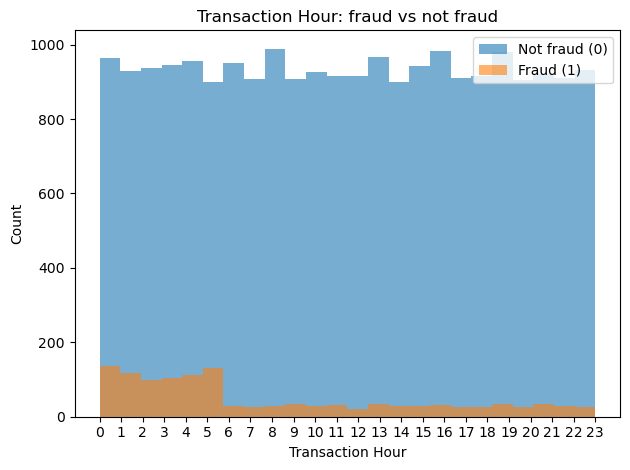

In [3]:
h0 = df[df[target] == 0]["Transaction Hour"]
h1 = df[df["Is Fraudulent"] == 1]["Transaction Hour"]

plt.hist(h0, bins=24, alpha=0.6, label="Not fraud (0)")
plt.hist(h1, bins=24, alpha=0.6, label="Fraud (1)")

plt.xticks(range(24))
plt.xlabel("Transaction Hour")
plt.ylabel("Count")
plt.title("Transaction Hour: fraud vs not fraud")
plt.legend()
plt.tight_layout()
plt.show()

### 2.2 Fraud based on Account Age 

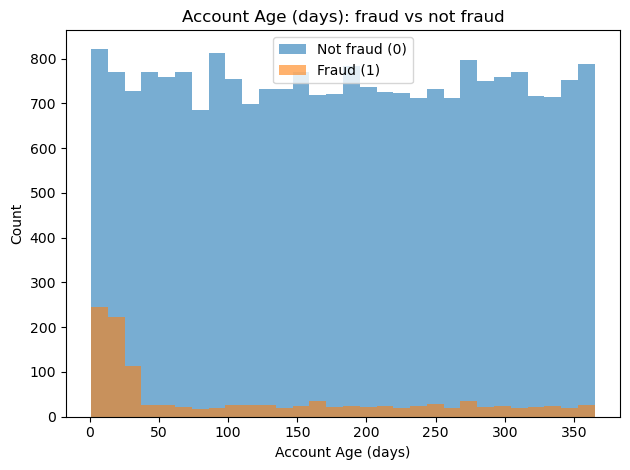

In [4]:
h0 = df[df[target] == 0]["Account Age Days"]
h1 = df[df["Is Fraudulent"] == 1]["Account Age Days" ]

plt.hist(h0, bins=30, alpha=0.6, label="Not fraud (0)")
plt.hist(h1, bins=30, alpha=0.6, label="Fraud (1)")

plt.xlabel("Account Age (days)")
plt.ylabel("Count")
plt.title("Account Age (days): fraud vs not fraud")
plt.legend()
plt.tight_layout()
plt.show()

### 2.3 Address Mismatch Analysis

Fraudsters often ship goods to a location different from the billing address associated with the stolen card. We check if address mismatch is a strong indicator of fraud.

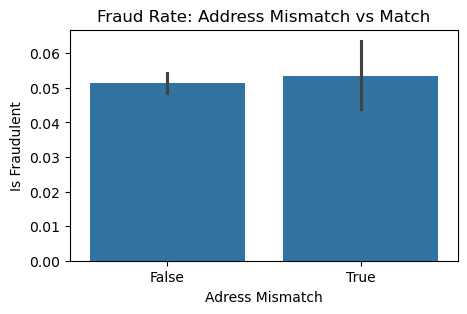

In [5]:
# Create temporary mismatch flag
df['Adress Mismatch'] = (df['Shipping Address'] != df['Billing Address'])

# Visualization
plt.figure(figsize=(5, 3))
sns.barplot(x='Adress Mismatch', y='Is Fraudulent', data=df) 
plt.title('Fraud Rate: Address Mismatch vs Match')
plt.show()

### 2.4 Transaction Amount Distribution

We compare the spread and median transaction amounts for fraud vs. non-fraud to see if fraudsters target higher-value transactions.

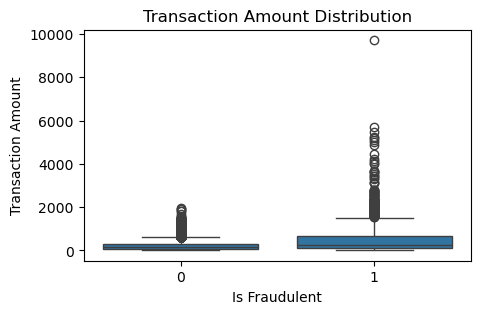

In [6]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='Is Fraudulent', y='Transaction Amount', data=df)
plt.title('Transaction Amount Distribution')
plt.show()

##### Transaction amount is likely a useful feature for our fraud detection model.
Fraud tends to involve larger and more variable amounts. But there’s overlap between the groups, so amount alone won’t perfectly separate fraud vs non-fraud.

### 2.5 Categorical Feature Analysis

We investigate fraud rates across different categories (Payment Method, Product Category, Device Used) to identify high-risk segments.

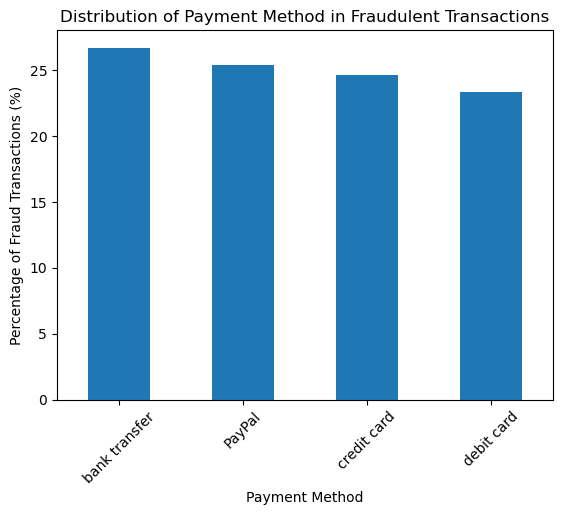

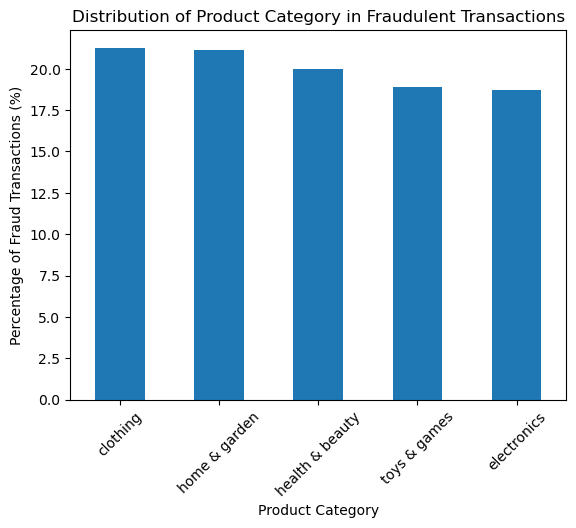

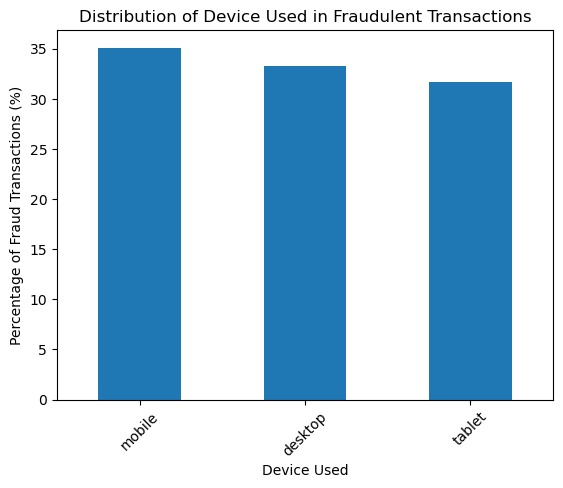

In [7]:
categorical_features = [
    "Payment Method",
    "Product Category",
    "Device Used"
]

for feature in categorical_features:
    fraud_only = df[df[target] == 1]

    category_pct = (
        fraud_only[feature]
        .value_counts(normalize=True) * 100
    )

    plt.figure()
    category_pct.plot(kind="bar")
    plt.title(f"Distribution of {feature} in Fraudulent Transactions")
    plt.ylabel("Percentage of Fraud Transactions (%)")
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.show()

## 3. Feature Engineering and Selection

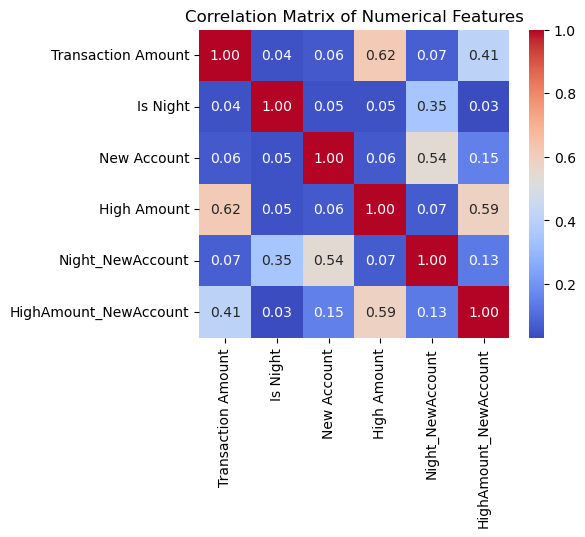

In [8]:
# Night transactions that happend between 12 and 5 AM 
df["Is Night"] = df["Transaction Hour"].between(0, 5).astype(int)

# New account: <= 40 days old (fraudsters often use fresh accounts)
df["New Account"] = (df["Account Age Days"] <= 40).astype(int)

# High amount - threshold based on
df["High Amount"] = (df["Transaction Amount"] > df["Transaction Amount"].quantile(0.99)).astype(int)

# Interaction Features
df["Night_NewAccount"] = df["Is Night"] * df["New Account"]
df["HighAmount_NewAccount"] = df["High Amount"] * df["New Account"]


# Initial Candidate Features
numerical_features = ["Transaction Amount", "Is Night", "New Account", "High Amount", "Night_NewAccount", "HighAmount_NewAccount"]

categorical_features = ["Payment Method", "Product Category", "Device Used"]

# Calculate Correlation Matrix
corr_matrix = df[numerical_features].corr().abs()

# Visualize
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [9]:
# Combine the lists of feature names (numeric + categorical) into one list.
features = numerical_features + categorical_features

X = df[features]
y = df[target]

# -----------------------------
# Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y)

## 5. Logistic Regression Model

In [10]:
# -----------------------------
# Logistic Regression Model
# -----------------------------
preprocess_lr = ColumnTransformer( # ColumnTransformer applies different preprocessing to different column groups
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop" # Drop unused columns
)

# Define the Logistic Regression classifier
logistic_regression = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

# -----------------------------
# Pipeline: preprocess + model
# -----------------------------
lr_pipe= Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("model", logistic_regression),
])

# Fit the full pipeline on the training data
lr_pipe.fit(X_train, y_train)

lr_pred = lr_pipe.predict(X_test)
lr_proba = lr_pipe.predict_proba(X_test)[:, 1]

### 5.1 Logistic Regression Evaluation

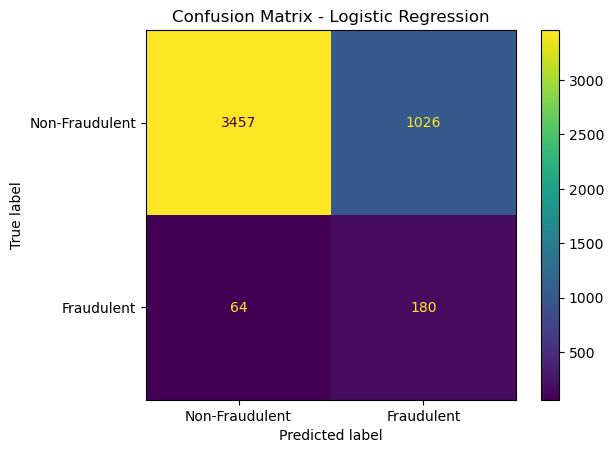


Classification Report:
              precision    recall  f1-score   support

           0     0.9818    0.7711    0.8638      4483
           1     0.1493    0.7377    0.2483       244

    accuracy                         0.7694      4727
   macro avg     0.5655    0.7544    0.5560      4727
weighted avg     0.9388    0.7694    0.8320      4727


AUC-PR (Average Precision): 0.39753521519797996


In [11]:
# Create and plot a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    lr_pred,
    display_labels=["Non-Fraudulent", "Fraudulent"]
)
disp.ax_.set_title("Confusion Matrix - Logistic Regression")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, lr_pred, digits=4))

print("\nAUC-PR (Average Precision):", average_precision_score(y_test, lr_proba))

## 6. Random Forest

In [12]:
# ==========================================
# Random Forest Model
# ==========================================

preprocess_forest = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features), # scaling is not necerasry for RF
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_forest),
    ("model", rf),
])

### 6.2 Hyperparameter Tunning with Cross Validation

In [13]:
param_dist = {
    "model__n_estimators": [300, 500, 700, 900, 1100],
    "model__max_depth": [None, 8, 12, 16, 20],
    "model__min_samples_split": [2, 5, 10, 20, 30],
    "model__min_samples_leaf": [1, 2, 4, 6, 8],
    "model__max_features": ["sqrt", "log2"],
    "model__bootstrap": [True]
}

# Stratified cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="average_precision",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    refit=True
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best parameters:\n", rf_search.best_params_)

Best parameters:
 {'model__n_estimators': 300, 'model__min_samples_split': 30, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 8, 'model__bootstrap': True}


### 6.3 Threshold Tuning (Business-driven)

In [14]:
# Probability prediction
rf_proba = best_rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, rf_proba)

# Choose threshold with recall ≥ 0.70
target_recall = 0.70

# Find highest threshold that still meets recall requirement
idx = np.where(recall >= target_recall)[0][-1]
best_threshold = thresholds[idx]
rf_pred_custom = (rf_proba >= best_threshold).astype(int)

print("Chosen threshold:", best_threshold)
print("Precision:", precision[idx])
print("Recall:", recall[idx])

Chosen threshold: 0.4695921217612703
Precision: 0.1669921875
Recall: 0.7008196721311475


### 6.4 Random Forest Evaluation

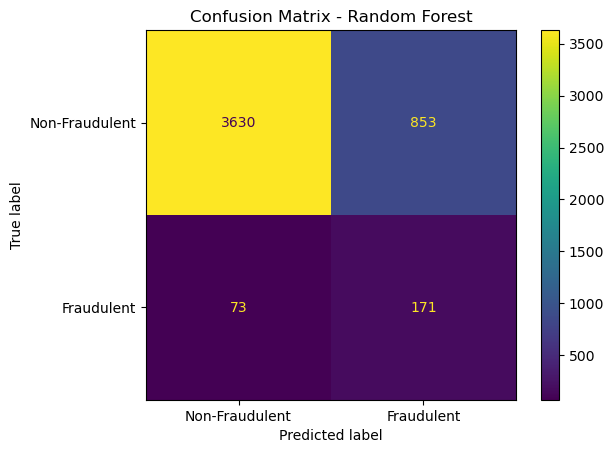


Classification Report:
              precision    recall  f1-score   support

           0     0.9803    0.8097    0.8869      4483
           1     0.1670    0.7008    0.2697       244

    accuracy                         0.8041      4727
   macro avg     0.5736    0.7553    0.5783      4727
weighted avg     0.9383    0.8041    0.8550      4727


Test AUC-PR (Average Precision): 0.3712463426429396


In [15]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    rf_pred_custom,
    display_labels=["Non-Fraudulent", "Fraudulent"]
)

disp.ax_.set_title("Confusion Matrix - Random Forest")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, rf_pred_custom, digits=4))

print("\nTest AUC-PR (Average Precision):", average_precision_score(y_test, rf_proba))

## 7. Support Vector Machine Model (LinearSVC) 

In [16]:
# ===========================
# Support Vector Machine (SVM) Model
# ===========================

# -----------------------------
# Preprocess 
# -----------------------------
preprocess_svm = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

# SVM with imbalance handling
svm_model = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42,
    dual="auto", # dual="auto" avoids FutureWarning
    max_iter=5000
)


svm_pipe = Pipeline(steps=[
    ("preprocess", preprocess_svm),
    ("model", svm_model),
])

### 7.1 Hyperparameter Tuning with Cross Validation

In [ ]:
# Hyperparameter space (fast + sensible for LinearSVC)
param_dist_svm = {
    "model__C": np.logspace(-4, 3, 40),    # C (regularization) 
    "model__tol": np.logspace(-5, -2, 20),       
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_search = RandomizedSearchCV(
    estimator=svm_pipe,
    param_distributions=param_dist_svm,
    n_iter=30,
    scoring="average_precision",   
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    refit=True
)


svm_search.fit(X_train, y_train)
best_svm = svm_search.best_estimator_
print("Best parameters:\n", svm_search.best_params_)

Best parameters:
 {'model__tol': 0.000379269019073225, 'model__C': 0.00015117750706156616}


### 7.2 Linear SVM Evaluation

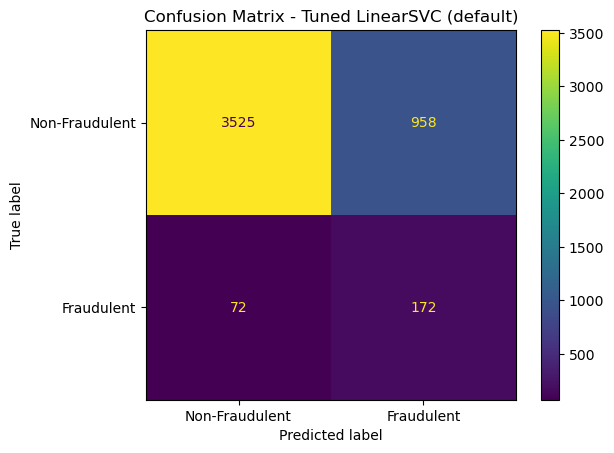


Classification Report:
              precision    recall  f1-score   support

           0     0.9800    0.7863    0.8725      4483
           1     0.1522    0.7049    0.2504       244

    accuracy                         0.7821      4727
   macro avg     0.5661    0.7456    0.5614      4727
weighted avg     0.9373    0.7821    0.8404      4727

Test AUC-PR (Average Precision): 0.3883922365623596


In [18]:
svm_pipe.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Non-Fraudulent", "Fraudulent"]
)
disp.ax_.set_title("Confusion Matrix - Tuned LinearSVC (default)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# To calculate AUC-PR, using decision_function (LinearSVC has no predict_proba)
test_scores = best_svm.decision_function(X_test)
print("Test AUC-PR (Average Precision):", average_precision_score(y_test, test_scores))